In [1]:
import tensorflow as tf
import os

DATASET_PATH = r"C:\Users\aashutosh kumar\Downloads\Sound_"  # Update if needed

# Load audio file paths and labels
audio_files = []
labels = []
for label in os.listdir(DATASET_PATH):
    label_path = os.path.join(DATASET_PATH, label)
    if os.path.isdir(label_path):
        for file in os.listdir(label_path):
            if file.endswith(".wav"):
                audio_files.append(os.path.join(label_path, file))
                labels.append(label)

print(f"Total Audio Files: {len(audio_files)}")
print(f"Example: {audio_files[0]} - Label: {labels[0]}")


Total Audio Files: 64727
Example: C:\Users\aashutosh kumar\Downloads\Sound_\bed\00176480_nohash_0.wav - Label: bed


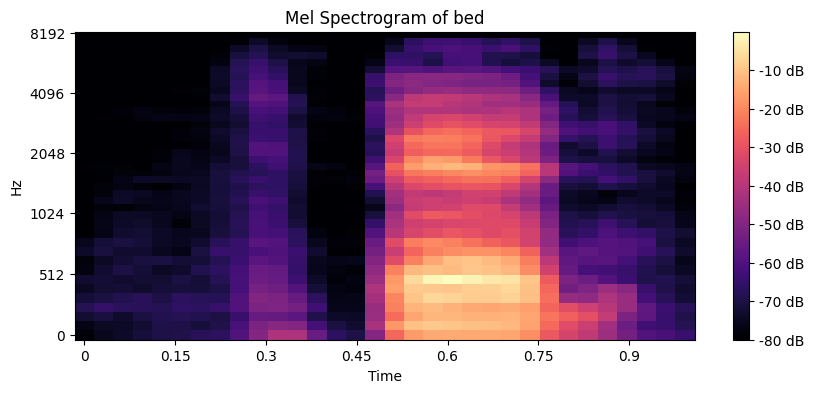

In [2]:
import numpy as np
import librosa.display
import matplotlib.pyplot as plt

example_file = audio_files[0]
y, sr = librosa.load(example_file, sr=16000)  

mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec_db, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title(f"Mel Spectrogram of {labels[0]}")
plt.show()

In [3]:
import numpy as np
import librosa
import os
from tqdm import tqdm  
import pickle

IMG_SIZE = (40, 100)  
SAMPLE_RATE = 16000

def extract_features(file_path):
    """ Convert audio file to Mel Spectrogram """
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=IMG_SIZE[0])
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    if mel_spec_db.shape[1] < IMG_SIZE[1]:  # If too short, pad
        pad_width = IMG_SIZE[1] - mel_spec_db.shape[1]
        mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode="constant")
    else:  # If too long, trim
        mel_spec_db = mel_spec_db[:, :IMG_SIZE[1]]
    
    return mel_spec_db

X, y = [], []
label_map = {label: i for i, label in enumerate(os.listdir(DATASET_PATH))}

for label in tqdm(os.listdir(DATASET_PATH)):
    label_path = os.path.join(DATASET_PATH, label)
    if os.path.isdir(label_path):
        for file in os.listdir(label_path):
            if file.endswith(".wav"):
                file_path = os.path.join(label_path, file)
                features = extract_features(file_path)
                X.append(features)
                y.append(label_map[label])

X = np.array(X)
y = np.array(y)

with open("speech_commands.pkl", "wb") as f:
    pickle.dump((X, y, label_map), f)

print("Feature extraction complete!")
print(f"Dataset Shape: {X.shape}, Labels Shape: {y.shape}")


100%|██████████| 35/35 [17:02<00:00, 29.21s/it]


✅ Feature extraction complete!
Dataset Shape: (64727, 40, 100), Labels Shape: (64727,)


In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.utils import to_categorical
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import pickle
import numpy as np

In [2]:
with open(r"C:\Users\aashutosh kumar\Downloads\speech_commands.pkl", "rb") as f:
    X, y, label_map = pickle.load(f)

In [3]:
X = X[..., np.newaxis]
y = to_categorical(y, num_classes=len(label_map))

In [4]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [5]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())

model.add(Dense(units=128, activation="relu"))
model.add(Dense(units=64, activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(units=len(label_map), activation="softmax"))

In [6]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - accuracy: 0.2599 - loss: 2.6226 - val_accuracy: 0.7690 - val_loss: 0.7891
Epoch 2/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.7270 - loss: 0.8868 - val_accuracy: 0.8054 - val_loss: 0.6291
Epoch 3/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 35s 21ms/step - accuracy: 0.7995 - loss: 0.6639 - val_accuracy: 0.8327 - val_loss: 0.5490
Epoch 4/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 90s 55ms/step - accuracy: 0.8235 - loss: 0.5654 - val_accuracy: 0.8447 - val_loss: 0.5173
Epoch 5/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 39s 24ms/step - accuracy: 0.8440 - loss: 0.5074 - val_accuracy: 0.8577 - val_loss: 0.4724
Epoch 6/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 37s 23ms/step - accuracy: 0.8587 - loss: 0.4498 - val_accuracy: 0.8657 - val_loss: 0.4495
Epoch 7/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 38s 23ms/step - accuracy: 0.8661 - loss: 0.4296 - val_accuracy: 0.8577 - val_loss: 0.4871
Epoch 8/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - accuracy: 0.8723 -

In [8]:
model.save("cnn_model.h5")

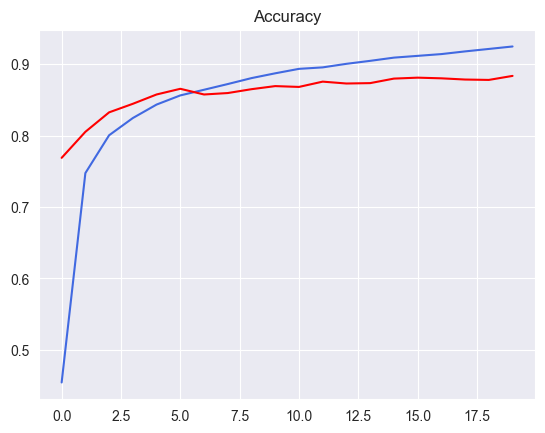

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.title("Accuracy")
plt.plot(history.history["accuracy"], color="royalblue")
plt.plot(history.history["val_accuracy"], color="red")
plt.show()

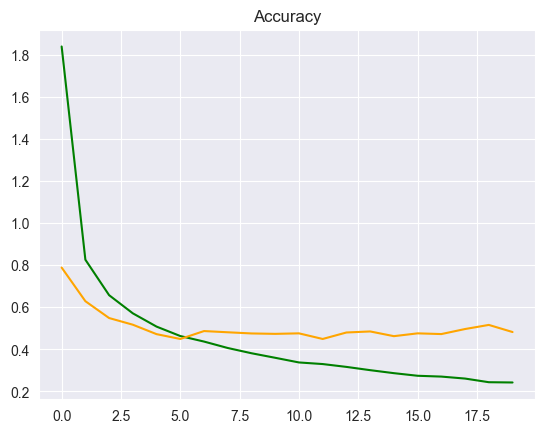

In [19]:
sns.set_style("darkgrid")
plt.title("Accuracy")
plt.plot(history.history["loss"], color="green")
plt.plot(history.history["val_loss"], color="orange")
plt.show()